Load required libraries

In [633]:
from src.data.data_loader import ImageLoader
import matplotlib.pyplot as plt
from src.data.data_transforms import *
from src.training.trainer import *
from src.training.optimizer import get_optimizer
from src.resnet import MyResNet18
from src.training.utils import *
from src.gradcam import *
from src.localization.scratches import findEdges as findScratch
from src.localization.inclusion import findEdges as findInclusion
from src.localization.patches import activeContours

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Stats and Transforms

The following cells uses the mean and standard deviation of the training images for certain tranformations for image augmentation. The augmented images make the training more robust

In [634]:
mean, std = 0.504953618600218, 0.009972093155668143 # Obtained using src/stats_helper
inp_size = (128, 128)
train_data_transform = get_train_transforms(inp_size=inp_size, pixel_mean=0.504953618600218, pixel_std=0.009972093155668143)
val_data_transform = get_val_transforms(inp_size=inp_size, pixel_mean=0.504953618600218, pixel_std=0.009972093155668143)

# Model and Training Parameters

For the defect type detection, we fine-tune a pretrained ResNet18.

In [635]:
model = MyResNet18()

/home/shuvo/anaconda3/envs/defect_detection/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shuvo/anaconda3/envs/defect_detection/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [636]:
batch_size = 256
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-5}
optimizer = get_optimizer(model, optimizer_config)

adam


In the following cells, adjust the "load_from_disk" parameter to use a fine-tuned model for inference/re-training.

In [637]:
runner = Trainer(
                    data_dir="data",
                    model=model,
                    optimizer=optimizer,
                    model_dir="models",
                    train_data_transforms=train_data_transform,
                    val_data_transforms=val_data_transform,
                    batch_size=batch_size,
                    inp_size=inp_size,
                    load_from_disk=True,
                )

/home/shuvo/Work/DefectDetection/src/training/trainer.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(self.model_dir, "checkpoint.p

The following cell runs the training loop and saves the best model.

In [638]:
# runner.run_training_loop(num_epochs=100)

In [639]:
# runner.plot_accuracy()

# Inference

The inference has two stages:
1. Detect type of defect
2. Isolate region of defect

The trained model is used for step 1. The method for isolating/localizing the defective regions depends on the type of defect, which is why step 1 is crucial.

Load the saved model from training.

In [640]:
# Load best model
model.load_state_dict(torch.load("models/checkpoint.pt")["model_state_dict"])

# Predict using best model
runner.predict(saved_model=model)

/tmp/ipykernel_11783/280619409.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/checkpoint.pt")["model_state_dict"])


The following cell has a list of defect-types which can be isolated currently. The isolation process for other defect-types has not yet been implemented.

In [641]:
canDetect = [2, 5]

## Visualize

The images with boxes show the regions of the defects. The boxes are drawn using the annotations in the database - they are not determined as a step in this project.

For the images of defect-types which have a localization method in place, the image with boxes is on the left, and the localized defects are on the right.

For the images of defect-types which do not have a localization method in place, the image with boxes is on the right, and the original image is on the right.

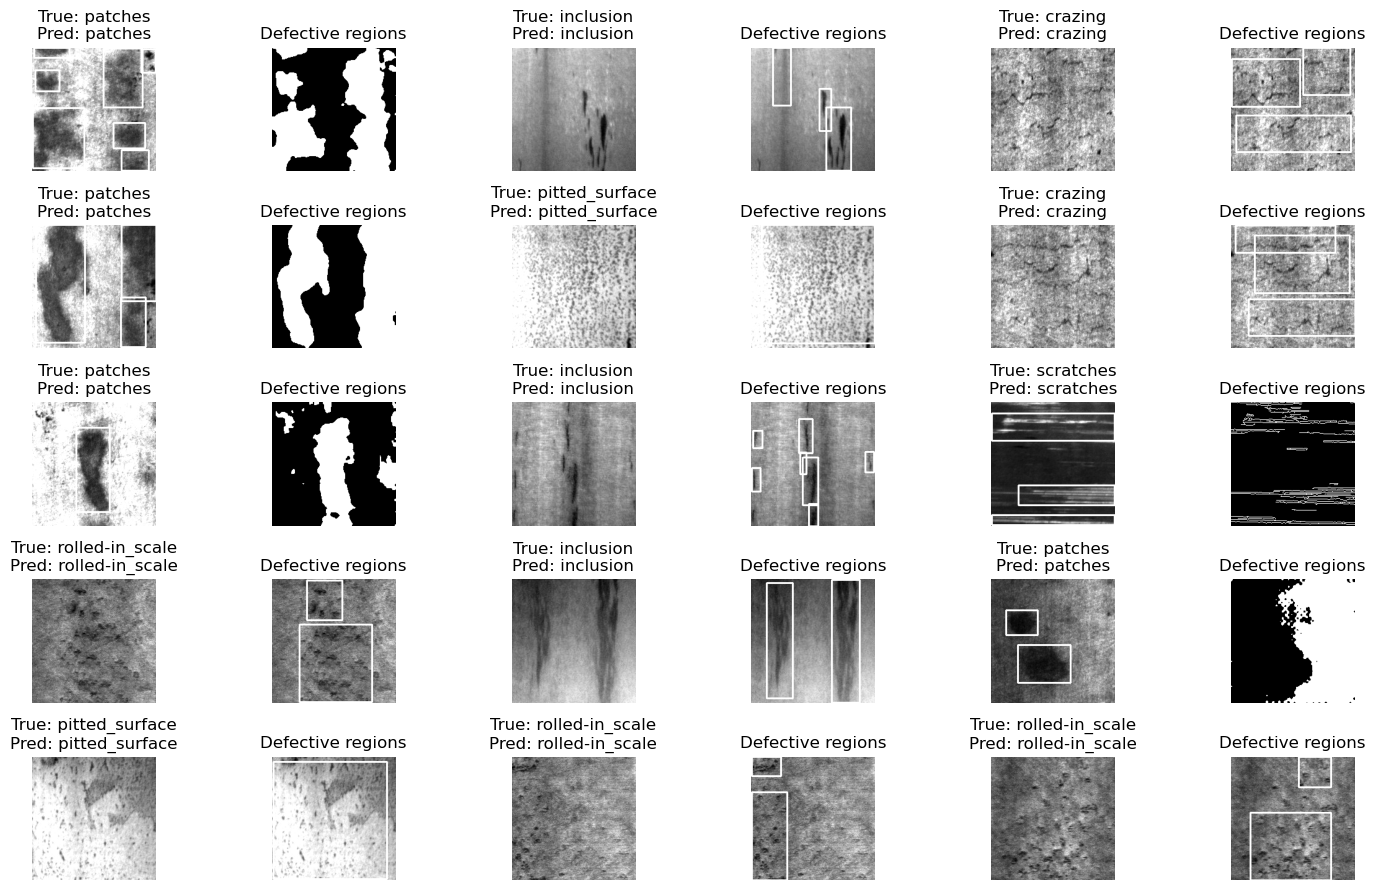

In [642]:
plt.figure(figsize=(15, 9))
randomIndices = np.random.choice(len(runner.val_dataset), 15, replace=False)
for i in range(15):
    prediction = runner.predictions[randomIndices[i]]
    trueLabel = runner.true_labels[randomIndices[i]]

    plt.subplot(5, 6, 2 * i + 1)
    boxes = extractBoxes(runner.valAnnDir[randomIndices[i]])
    originalImage = np.array(Image.open(runner.valImageDir[randomIndices[i]]).convert(mode='L'))
    boxedImage = overlayBoundingBox(originalImage, boxes)
    if prediction in canDetect:
        plt.imshow(boxedImage, cmap='gray')
    else:
        plt.imshow(originalImage, cmap='gray')
    plt.axis("off")
    plt.title(f"True: {runner.val_dataset.reverseLabelInfo[trueLabel]}"
              f"\nPred: {runner.val_dataset.reverseLabelInfo[prediction]}")

    plt.subplot(5, 6, 2 * i + 2)
    if prediction == 5:
        defect = findScratch(originalImage)
    elif prediction == 2:
        defect = activeContours(originalImage)
    else:
        defect = overlayBoundingBox(originalImage, boxes)
    
    if prediction in canDetect:
        plt.imshow(defect, cmap='gray')
    else:
        plt.imshow(boxedImage, cmap='gray')
    plt.axis("off")
    plt.title("Defective regions")
plt.tight_layout()
plt.show()

## Confusion Matrix

The confusion matrix of the classification from step 1 is shown below. The defect type "Inclusion" is the most incorrectly classified type because of its similarities with other defect types.

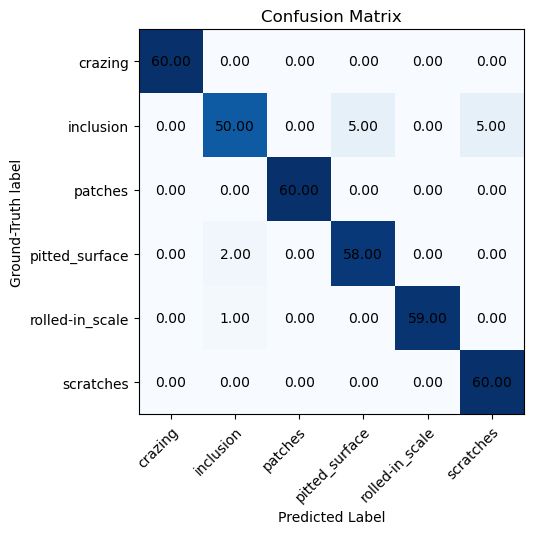

In [643]:
confusionMatrix = runner.generate_confusion_matrix()
plot_confusion_matrix(confusionMatrix, list(runner.val_dataset.labelInfo))